Code source: https://github.com/ihamdi/Dogs-vs-Cats-Classification/blob/main/pytorch-cat-vs-dog.ipynb

In [18]:
#%pip install kaggle

In [19]:
from kaggle.api.kaggle_api_extended import KaggleApi

import numpy as np
import os
import zipfile

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader


import tqdm
from sklearn.model_selection import train_test_split
import PIL
import random

In [20]:
competition = "dogs-vs-cats"
download_path = "."
train_val_test_split = (0.7,0.2,0.1)
batch_size = 96
num_workers=6
drop_rate = 0.23
lr = 2e-3
epochs = 5

In [21]:
# Using Kaggle API to download data

api = KaggleApi()
api.authenticate()

if competition+".zip" in os.listdir(download_path):
    print("***Dataset present at local path. Skipping download***")
else:
    print("Downloading dataset...")
    api.competition_download_files("dogs-vs-cats",path=download_path)
    print("Done")

***Dataset present at local path. Skipping download***


In [22]:
import os
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/rafael2/code/Users/rafael/distillation/notebooks


In [23]:
# Extracting Data 

#print("Extracting training files...")
#dataset = zipfile.ZipFile("dogs-vs-cats.zip", 'r')
#dataset.extract("train.zip")
train_dir = "../data/train/"
#trainZip = zipfile.ZipFile("train.zip", 'r')
#print(len(trainZip.namelist())-1,"training images found") #Removing 1 from len(trainZip.namelist()) since train/ is counted
#trainZip.extractall(path=download_path)
#print("Done")


# Cleaning up
# os.remove(dataset.filename) if you'd like to remove the original zip file from Kaggle as well

In [24]:
train_files = random.sample(os.listdir(train_dir),k = 24000)
# Only select jpg files
train_files = [f for f in train_files if '.jpg' in f]


In [25]:
# Defining augmentations

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [26]:
# Creating dataset

class DogsVsCatsDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = val_transform):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = PIL.Image.open(os.path.join(self.dir, self.file_list[idx]))
        img = self.transform(img)
        img = np.array(img)
        if 'dog' in self.file_list[idx]:
            self.label = 1
        else:
            self.label = 0
        return img.astype('float32'), self.label


train_files, test_files = train_test_split(train_files, 
                                    test_size=train_val_test_split[2], 
                                    random_state=42
                                    )
train_files, valid_files = train_test_split(train_files,
                                    test_size=train_val_test_split[1]/train_val_test_split[0], 
                                    random_state=42
                                    )

TrainDataSet = DogsVsCatsDataset(train_files, dir = train_dir, mode='train', transform = train_transform)
TrainDataLoader = DataLoader(TrainDataSet, batch_size = batch_size, shuffle=True, num_workers=num_workers)

ValidDataSet = DogsVsCatsDataset(valid_files, dir = train_dir, mode='valid')
ValidDataLoader = DataLoader(ValidDataSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

TestDataSet = DogsVsCatsDataset(test_files, dir = train_dir, mode='test')
TestDataLoader = DataLoader(TestDataSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

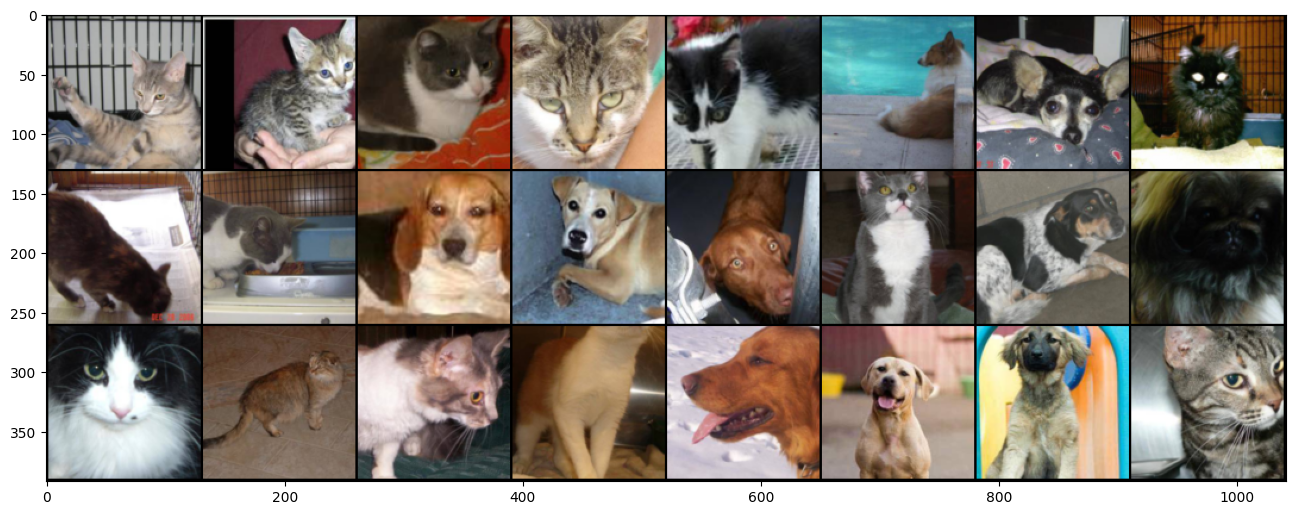

In [27]:
# Visualising to ensure augmentions/transformations done without errors

samples, labels = iter(TrainDataLoader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [28]:
# Defining model and training device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torchvision.models.densenet121(weights='DEFAULT',drop_rate=drop_rate)

# Freeze:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
model = model.to(device)

Epoch 1 / 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:55<00:00,  1.40 Iterations/s]


 Total Loss: 44.8596, Accuracy: 88.0 %


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:47<00:00,  1.37 Iterations/s]


-----------------------------> Validation Loss: 8.8781, Accuracy: 95.1 %
Epoch 2 / 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:54<00:00,  1.40 Iterations/s]


 Total Loss: 35.0094, Accuracy: 90.8 %


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:45<00:00,  1.43 Iterations/s]


-----------------------------> Validation Loss: 8.7715, Accuracy: 95.1 %
Epoch 3 / 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:52<00:00,  1.43 Iterations/s]


 Total Loss: 35.4717, Accuracy: 90.7 %


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:44<00:00,  1.47 Iterations/s]


-----------------------------> Validation Loss: 9.3973, Accuracy: 95.0 %
Epoch 4 / 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:53<00:00,  1.42 Iterations/s]


 Total Loss: 35.2236, Accuracy: 90.6 %


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:45<00:00,  1.44 Iterations/s]


-----------------------------> Validation Loss: 8.5570, Accuracy: 95.1 %
Epoch 5 / 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:52<00:00,  1.43 Iterations/s]


 Total Loss: 35.0369, Accuracy: 90.6 %


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:44<00:00,  1.45 Iterations/s]


-----------------------------> Validation Loss: 8.8327, Accuracy: 95.4 %


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.31 Iterations/s]


-----------------------------> Testing Accuracy: 95.1 %


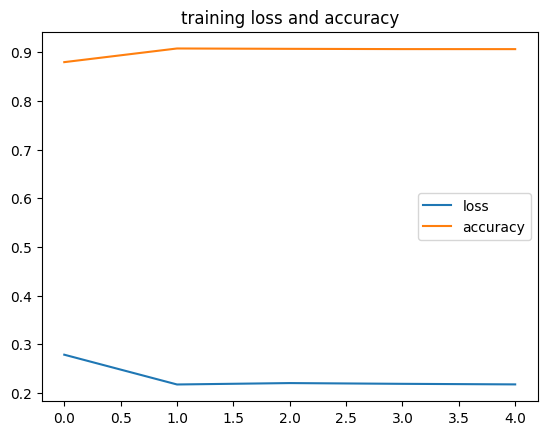

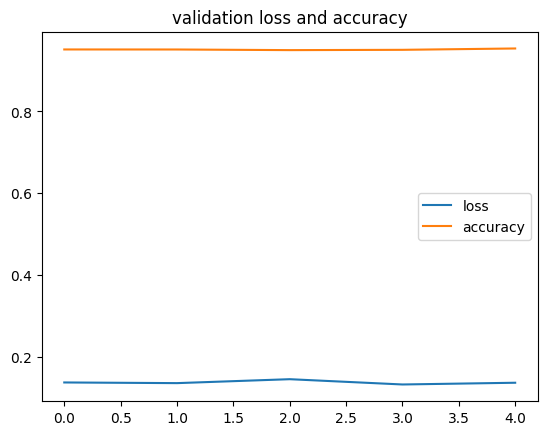

In [29]:
# Training

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
test_acc_list = []

for epoch in range(epochs):
    print("Epoch",epoch+1,"/",epochs)
    model.train()
    train_loss = 0
    train_acc = 0
    itr = 1
    tot_itr = len(TrainDataLoader)
    for samples, labels in tqdm.tqdm(TrainDataLoader, desc = "Training", unit = " Iterations"):
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        train_acc+= torch.mean(correct.float())
        torch.cuda.empty_cache()
        itr += 1
        
    train_loss_list.append(train_loss/tot_itr)
    train_acc_list.append(train_acc.item()/tot_itr)
    print(' Total Loss: {:.4f}, Accuracy: {:.1f} %'.format(train_loss, train_acc/tot_itr*100))

    model.eval()
    valid_loss=0
    valid_acc=0
    itr=1
    tot_itr = len(ValidDataLoader)
    for samples, labels in tqdm.tqdm(ValidDataLoader, desc = "Validating", unit = " Iterations"):
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            valid_acc += torch.mean(correct.float())
            torch.cuda.empty_cache()
            itr += 1
            
    valid_loss_list.append(valid_loss/tot_itr)
    valid_acc_list.append(valid_acc.item()/tot_itr)
    print('-----------------------------> Validation Loss: {:.4f}, Accuracy: {:.1f} %'.format(valid_loss, valid_acc/tot_itr*100))

test_acc = 0
itr = 1
tot_itr = len(TestDataLoader)
for samples, labels in tqdm.tqdm(TestDataLoader, desc = "Testing", unit = " Iterations"):
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_acc += torch.mean(correct.float())
            torch.cuda.empty_cache()
            itr += 1
print('-----------------------------> Testing Accuracy: {:.1f} %'.format(test_acc/tot_itr*100))

plt.plot(train_loss_list, label='loss')
plt.plot(train_acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.show()

plt.plot(valid_loss_list, label='loss')
plt.plot(valid_acc_list, label='accuracy')
plt.legend()
plt.title('validation loss and accuracy')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.show()

In [30]:
torch.save(model, 'densenet121.pt')